In [1]:
# Cell 1: Import necessary libraries
import os
import glob
import nrrd
import nibabel as nib
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from scipy.ndimage import binary_opening
from scipy.ndimage import zoom as resize

import torch
from torch.utils.data import Dataset, DataLoader
import monai
from monai.networks.nets import resnet10

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import torch.optim as optim
import torch.nn as nn

import os
import datetime
import logging

In [2]:
def data_investigation(all_patient_data, all_labels):
    # Create a dictionary to store the counts of each unique shape
    shape_counts = defaultdict(int)
    patient_shapes = {}  # Dictionary to store shapes for each patient
    
    # Iterate over all the patient data
    for idx, patient in enumerate(all_patient_data):
        # You can choose any sequence, since they all have the same shape
        sequence_data = patient['T1-3D.nii']
        
        # Count the shape of the sequence data
        shape_counts[sequence_data.shape] += 1
        patient_shapes[patient['patient_id']] = sequence_data.shape

    return shape_counts, patient_shapes


def plot_shape_counts(shape_counts, top_n=24):
    # Sort the shapes by frequency in descending order and keep only the top N
    sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Convert the keys (shapes) to strings so they can be used as labels
    labels = range(1, len(sorted_shapes)+1)
    counts = [count for _, count in sorted_shapes]

    # Create a new figure with a larger size
    plt.figure(figsize=(20, 10))

    # Create the bar plot
    bars = plt.bar(labels, counts, color='skyblue')

    # Add text above each bar
    for i, (shape, count) in enumerate(sorted_shapes):
        plt.text(i+1, count + 1, str(shape), ha='center', va='bottom', rotation=0, color='blue')
        plt.text(i+1, count/2, str(count), ha='center', va='center', color='black', fontweight='bold')

    plt.title('Distribution of Top {} Sequence Shapes'.format(top_n), fontsize=16)
    plt.xlabel('Shape Index', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(labels, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Ensures that the annotations don't overlap
    
    # Display the plot
    plt.show()




def prepare_data_for_plotting(shape_counts):
    widths, heights, depths, frequencies = [], [], [], []
    for shape, count in shape_counts.items():
        width, height, depth = shape
        widths.append(width)
        heights.append(height)
        depths.append(depth)
        frequencies.append(count)
    return widths, heights, depths, frequencies


def round_to_power_of_two(n):
    return 2**np.round(np.log2(n))

def plot_3d_shape_distribution(shape_counts):
    # Prepare the data for plotting
    rounded_shapes = {(round_to_power_of_two(w), round_to_power_of_two(h), round_to_power_of_two(d)): c 
                      for (w, h, d), c in shape_counts.items()}
    sorted_shapes = sorted(rounded_shapes.items(), key=lambda x: x[1], reverse=True)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define a color map
    cmap = plt.get_cmap("viridis")

    for (w, h, d), c in sorted_shapes:
        # Define the vertices of the cube
        Z = np.array([[0, 0, 0],
                      [w, 0, 0],
                      [w, h, 0],
                      [0, h, 0],
                      [0, 0, d],
                      [w, 0, d],
                      [w, h, d],
                      [0, h, d]])

        # Define the edges of the cube
        edges = [[Z[j], Z[k]] for j, k in zip([0, 1, 5, 6, 4, 2, 3, 7], [1, 5, 6, 2, 0, 3, 7, 4])]

        # Create the 3D surface
        faces = Poly3DCollection(edges, linewidths=1, edgecolors='r', alpha=0.2)
        faces.set_facecolor(cmap(c/np.max(list(shape_counts.values()))))

        ax.add_collection3d(faces)

    # Set the labels and title
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')
    ax.set_title('3D Shape Distribution')

    plt.show()

    # Print the most common rounded shape
    most_common_shape = sorted_shapes[0][0]
    print(f"The most common rounded shape is {most_common_shape}")




def load_data(mri_path, seg_path):
    mri_img = nib.load(mri_path)
    mri_data = mri_img.get_fdata()
    seg_data, _ = nrrd.read(seg_path)
    return mri_data, seg_data


def extract_roi(mri_data, seg_data):
    return crop_to_roi(mri_data * seg_data)



def process_patient_folder(patient_folder):
    sequence_files = {}
    sequence_types = ['T1-3D.nii', 'T1c-3D.nii', 'T2-3D.nii', 'FLAIR-3D.nii']

    # Get paths to the MRI data files
    for sequence_type in sequence_types:
        sequence_files[sequence_type] = glob.glob(
            os.path.join(patient_folder, sequence_type))
        if not sequence_files[sequence_type]:
            print(f"Missing {sequence_type} in folder: {patient_folder}")
            return None

    # Get path to the segmentation file
    seg_files = glob.glob(os.path.join(patient_folder, '*.nrrd'))
    seg_pattern = re.compile(r'segmentation\.seg', re.IGNORECASE)
    seg_file = None

    for file in seg_files:
        if seg_pattern.search(file):
            seg_file = file
            break

    if not seg_file:
        print(
            f"Missing segmentation.seg.nrrd file in folder: {patient_folder}")
        return None

    rois = {}
    # Load MRI data and segmentation for each sequence and extract ROI
    for sequence_type in sequence_types:
        mri_data, seg_data = load_data(
            sequence_files[sequence_type][0], seg_file)
        roi = extract_roi(mri_data, seg_data)
        # print(f'ROI size for sequence {sequence_type}: {roi.shape}')
        rois[sequence_type] = roi

    return rois


def process_all_patients(data_dir, label_dict):
    # Get a list of all patient folders in data_dir
    patient_folders = [f for f in os.listdir(
        data_dir) if os.path.isdir(os.path.join(data_dir, f))]

    # Sort the patient_folders list to ensure it's in the same order as the labels
    patient_folders.sort(key=lambda x: int(x))

    all_patient_data = []
    all_labels = []

    for folder in patient_folders:
        patient_id = int(folder)  # Convert folder name to integer
        patient_folder = os.path.join(data_dir, folder)

        patient_data = process_patient_folder(patient_folder)
        if patient_data is not None:
            # Add the patient_id to the patient_data dictionary
            patient_data['patient_id'] = patient_id
            all_patient_data.append(patient_data)
            all_labels.append(label_dict[patient_id])

    print(
        f"Total patient folders: {len(patient_folders)}, successfully processed: {len(all_patient_data)}")
    return all_patient_data, all_labels


# Function to visualize 3D ROI
def visualize_3d_roi(roi, sequence_type, threshold=0.1):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define coordinates
    x, y, z = np.where(roi > threshold)

    ax.scatter(x, y, z, c='red', alpha=0.6, s=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()


def create_label_dict(label_excel_path):
    # Read the Excel file into a DataFrame
    df = pd.read_excel(label_excel_path)

    # Create a dictionary mapping patient names to labels
    label_dict = df.set_index('Subject number')['Infiltration'].to_dict()

    return label_dict


def get_bounding_box(data, threshold=0, margin=5):
    """
    Returns the bounding box coordinates (min and max) for the ROI.
    """
    x = np.any(data > threshold, axis=(1,2))
    y = np.any(data > threshold, axis=(0,2))
    z = np.any(data > threshold, axis=(0,1))

    xmin, xmax = np.where(x)[0][[0, -1]]
    ymin, ymax = np.where(y)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    # Adding margin
    xmin = max(xmin - margin, 0)
    xmax = min(xmax + margin, data.shape[0]-1)
    ymin = max(ymin - margin, 0)
    ymax = min(ymax + margin, data.shape[1]-1)
    zmin = max(zmin - margin, 0)
    zmax = min(zmax + margin, data.shape[2]-1)

    return xmin, xmax, ymin, ymax, zmin, zmax

def crop_to_roi(data, threshold=0, margin=5):
    """
    Crop the 3D data to the region of interest based on a threshold.
    """
    # Apply binary opening to remove small artifacts
    processed_data = binary_opening(data > threshold)
    xmin, xmax, ymin, ymax, zmin, zmax = get_bounding_box(processed_data, threshold, margin)
    return data[xmin:xmax+1, ymin:ymax+1, zmin:zmax+1]


In [3]:
# Cell 3: Load the data
data_dir = "/home/slt2870/Glioblastoma_Infillstration_Classification/data/Brainstem Annotations"
label_dir = "/home/slt2870/Glioblastoma_Infillstration_Classification/data/Deidentified Brainstem_dicoms full set with hashed IDs.xlsx"

label_dict = create_label_dict(label_dir)
all_patient_data, all_labels = process_all_patients(data_dir, label_dict)

np.save('processed_patient_data.npy', all_patient_data)
np.save('labels.npy', all_labels)

Missing FLAIR-3D.nii in folder: /home/slt2870/Glioblastoma_Infillstration_Classification/data/Brainstem Annotations/09
Missing T2-3D.nii in folder: /home/slt2870/Glioblastoma_Infillstration_Classification/data/Brainstem Annotations/19
Missing T2-3D.nii in folder: /home/slt2870/Glioblastoma_Infillstration_Classification/data/Brainstem Annotations/33
Total patient folders: 27, successfully processed: 24


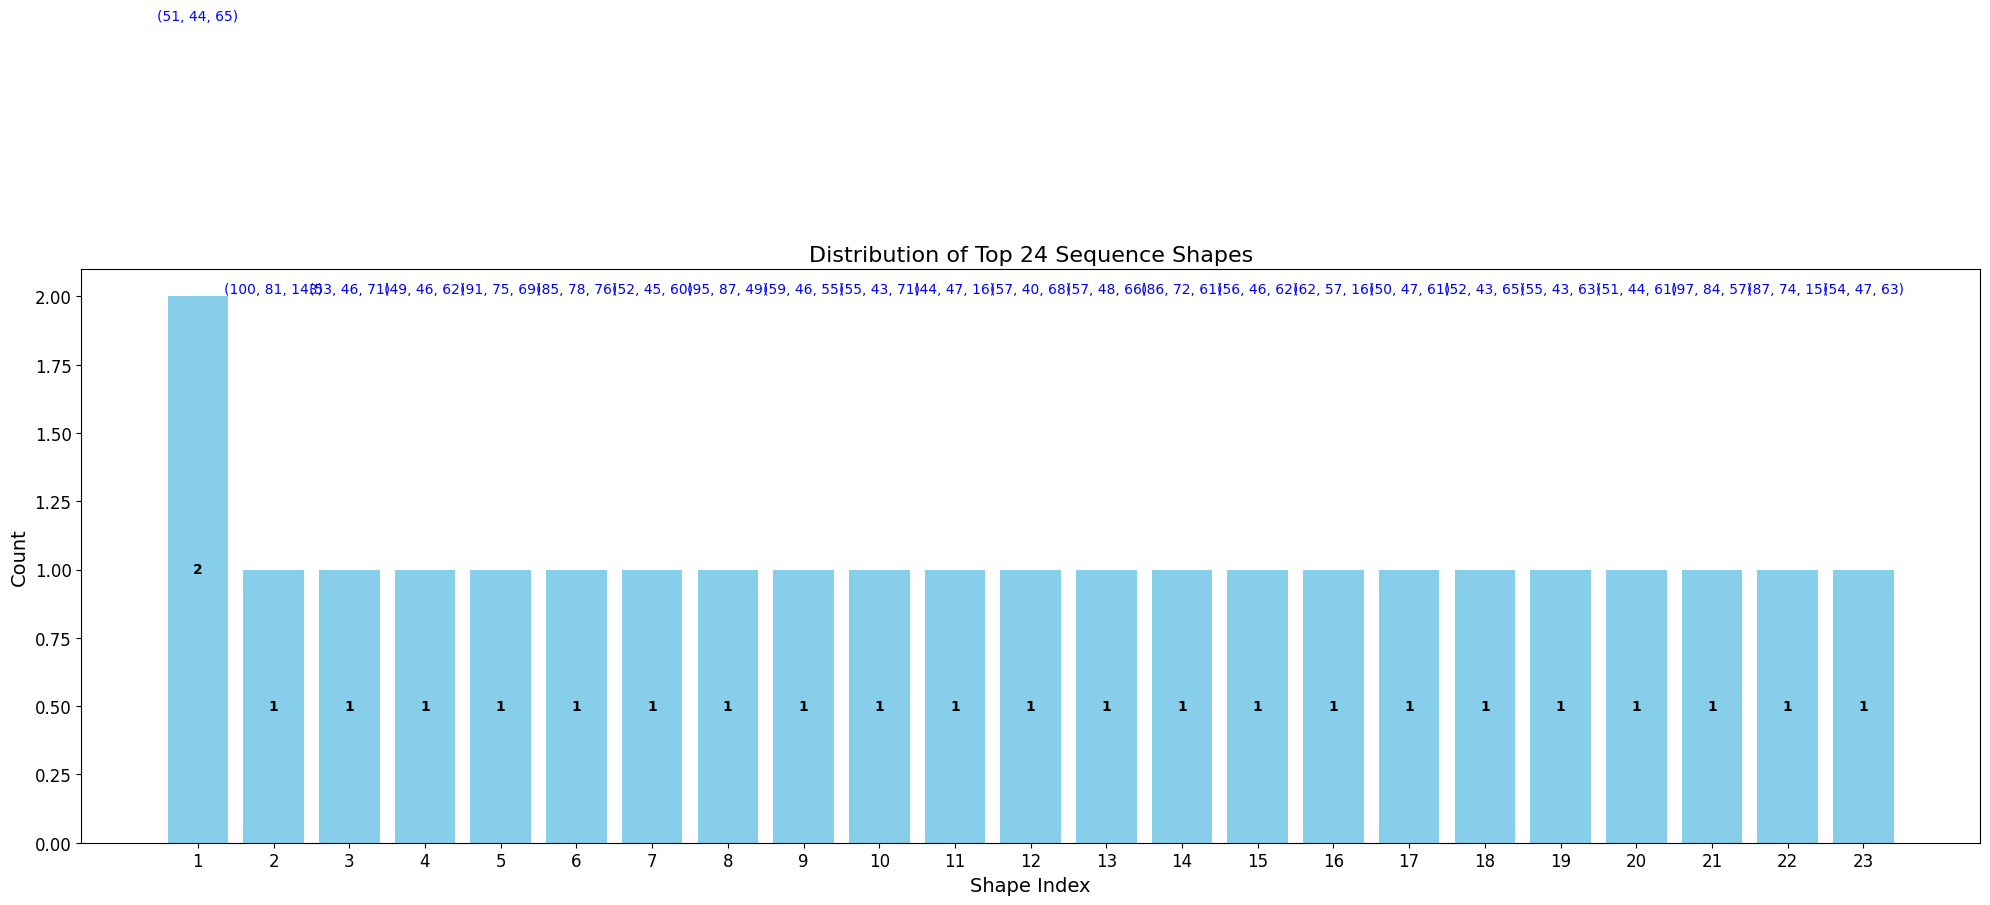

Patient 1: Shape (100, 81, 143)
Patient 2: Shape (53, 46, 71)
Patient 3: Shape (49, 46, 62)
Patient 4: Shape (91, 75, 69)
Patient 5: Shape (85, 78, 76)
Patient 6: Shape (52, 45, 60)
Patient 8: Shape (95, 87, 49)
Patient 10: Shape (59, 46, 55)
Patient 11: Shape (55, 43, 71)
Patient 16: Shape (44, 47, 16)
Patient 17: Shape (57, 40, 68)
Patient 18: Shape (57, 48, 66)
Patient 20: Shape (51, 44, 65)
Patient 21: Shape (86, 72, 61)
Patient 22: Shape (56, 46, 62)
Patient 23: Shape (62, 57, 16)
Patient 24: Shape (51, 44, 65)
Patient 25: Shape (50, 47, 61)
Patient 26: Shape (52, 43, 65)
Patient 27: Shape (55, 43, 63)
Patient 28: Shape (51, 44, 61)
Patient 29: Shape (97, 84, 57)
Patient 30: Shape (87, 74, 15)
Patient 32: Shape (54, 47, 63)


In [4]:
# Cell 4: Shape Distribution Analysis
shape_counts, patient_shapes = data_investigation(all_patient_data, all_labels)
plot_shape_counts(shape_counts)
for patient_id, shape in patient_shapes.items():
    print(f"Patient {patient_id}: Shape {shape}")


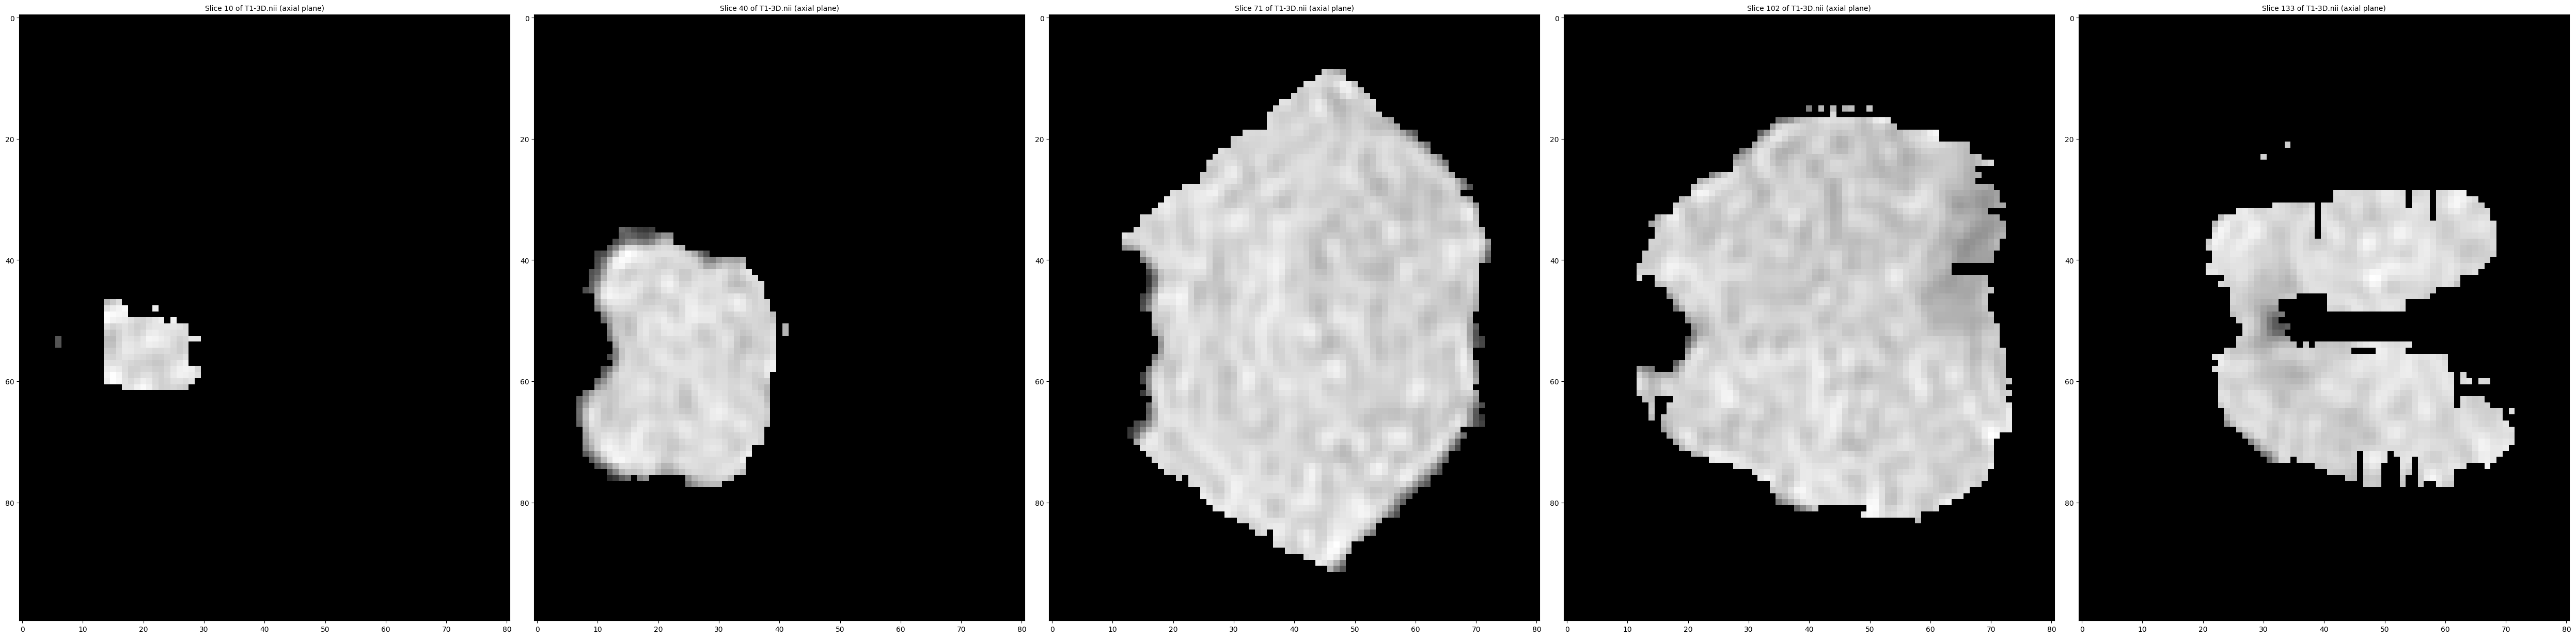

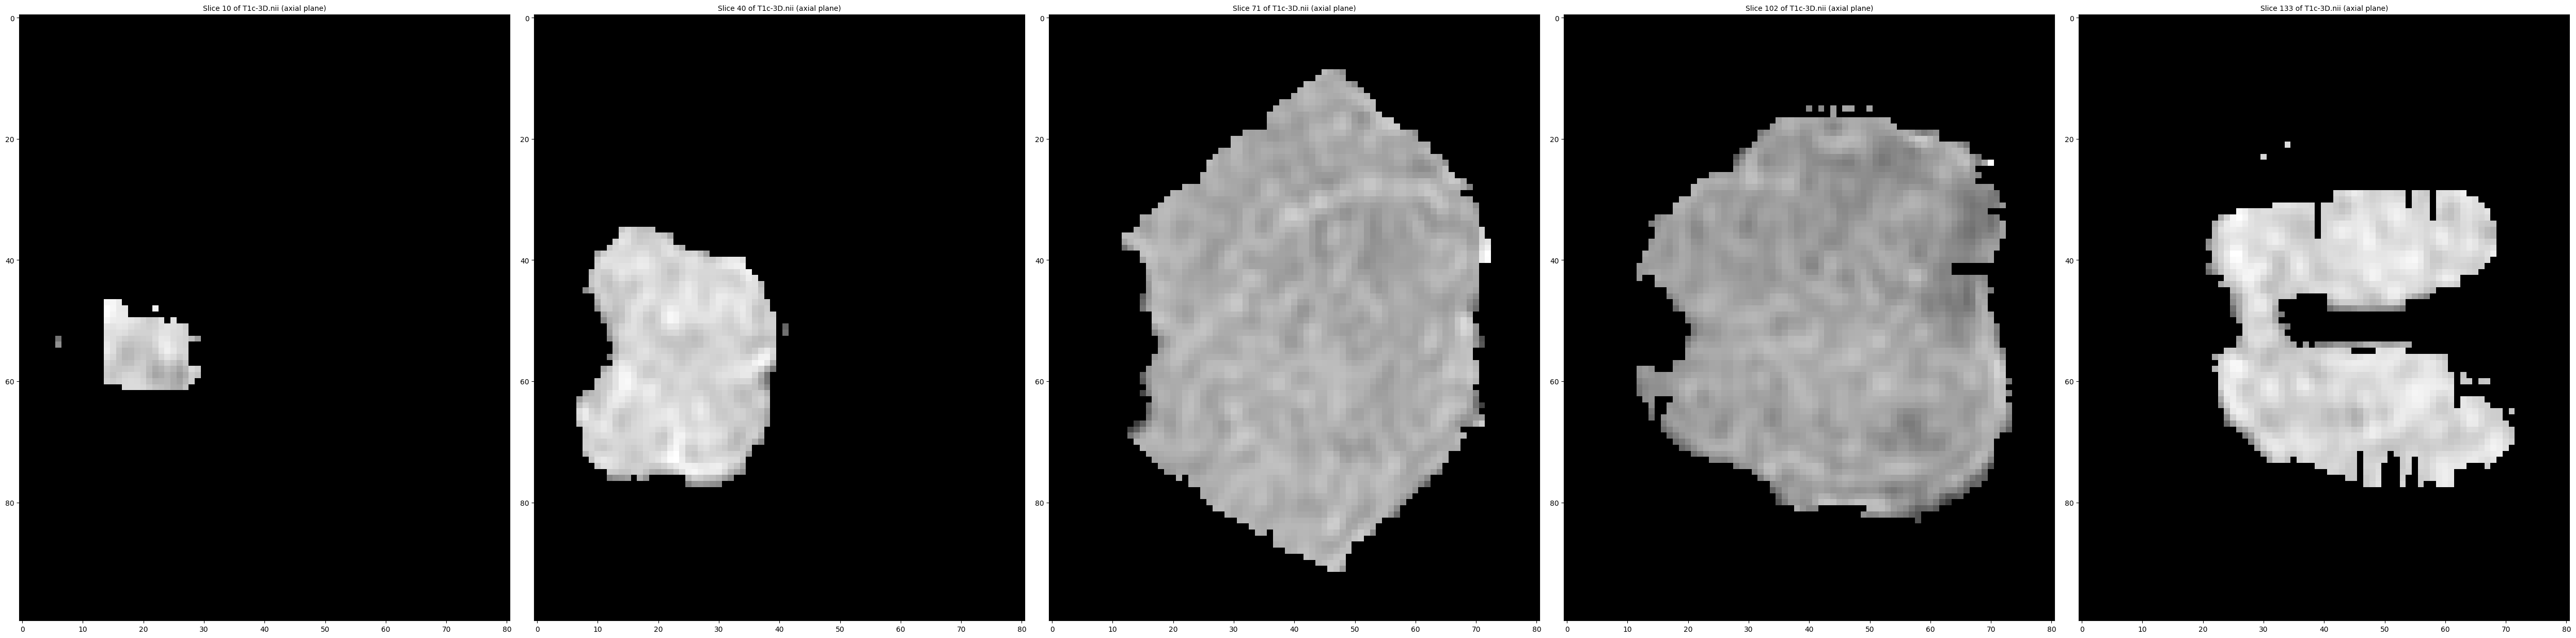

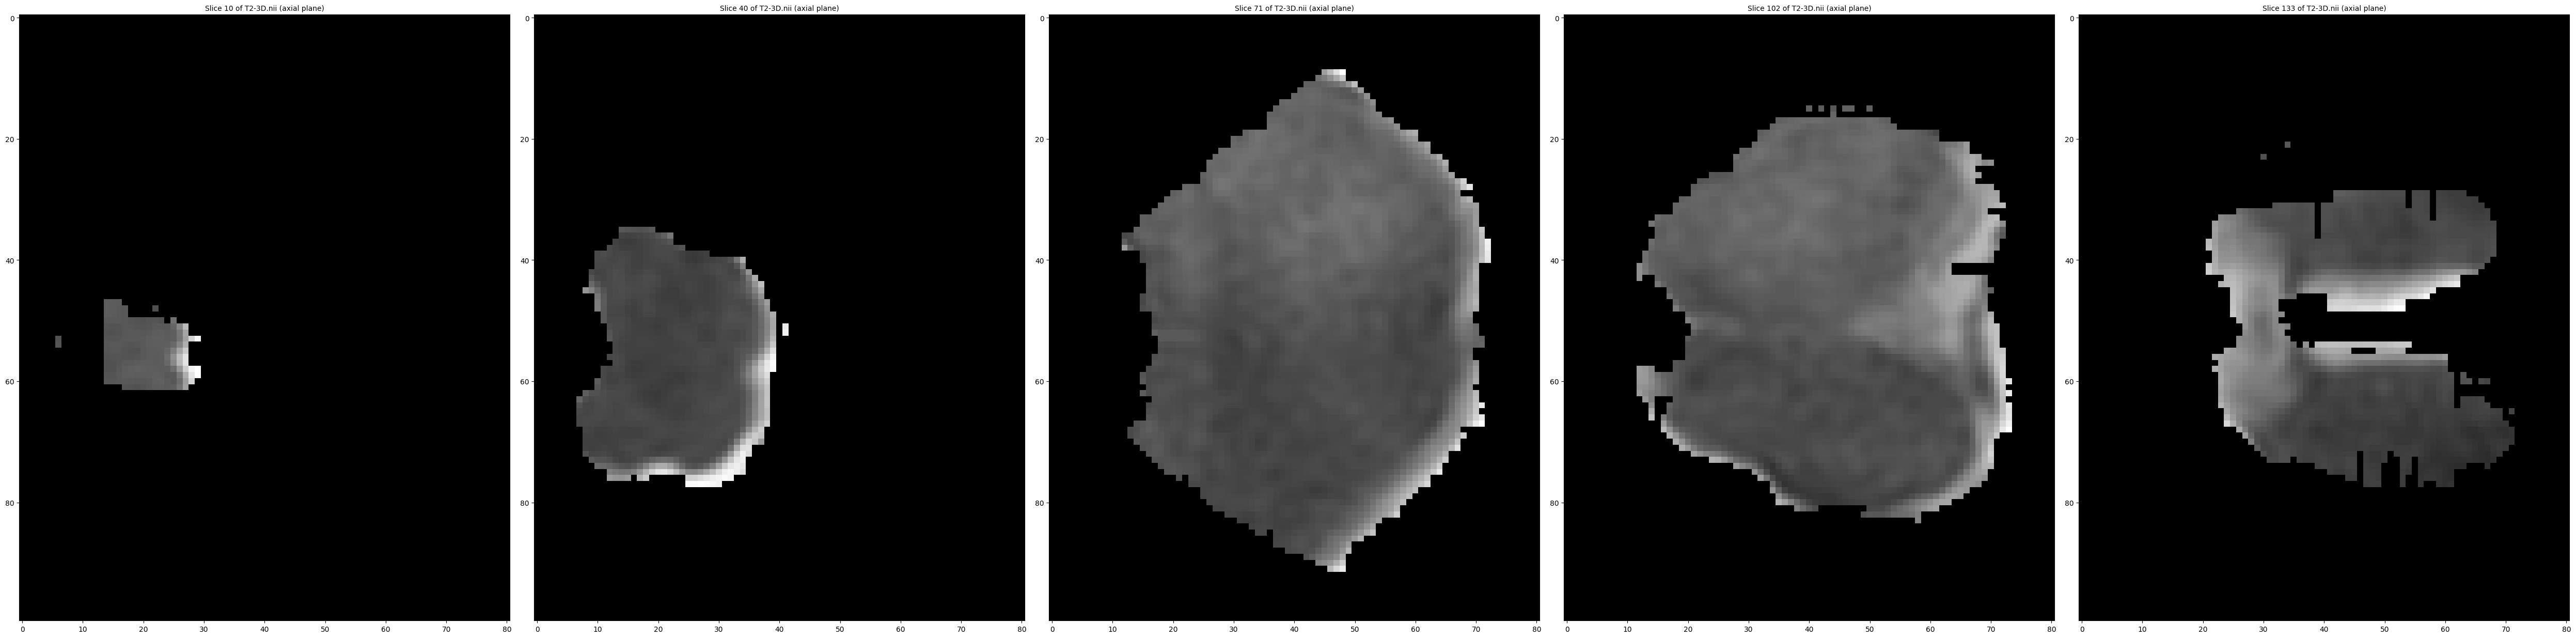

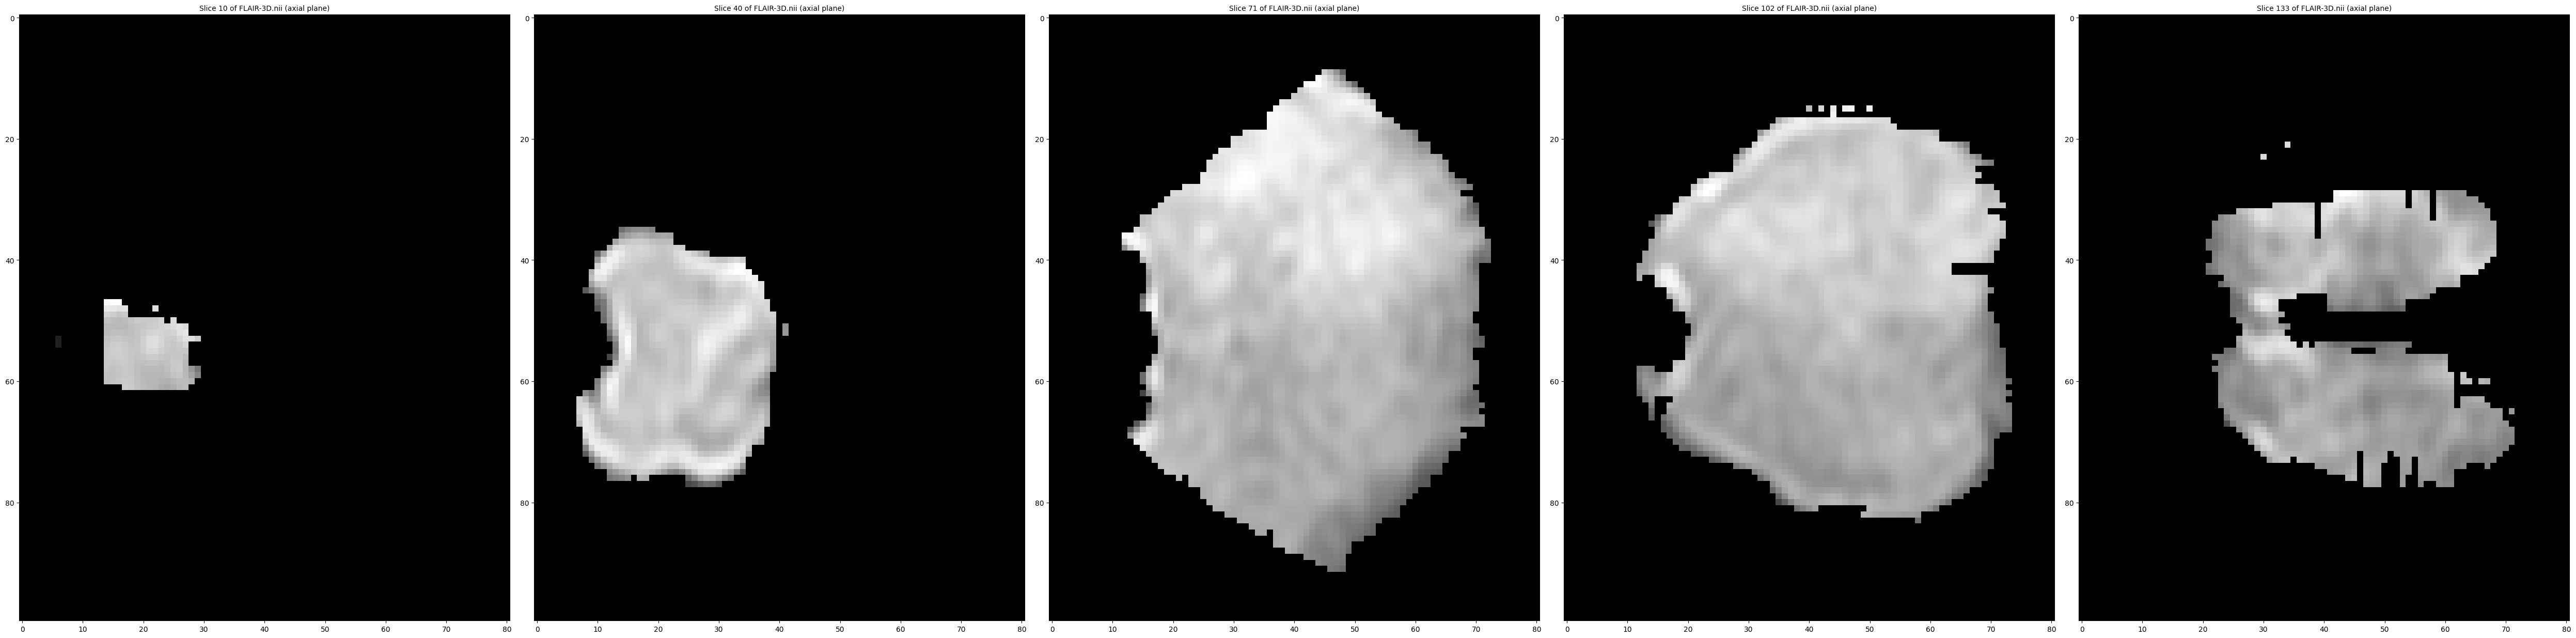

In [5]:
# Cell 5: Visualizing random slices from a random patient's MRI sequences
def visualize_slices(patient_data, num_slices=5, plane='axial'):
    sequence_types = ['T1-3D.nii', 'T1c-3D.nii', 'T2-3D.nii', 'FLAIR-3D.nii']
    for sequence in sequence_types:
        data = patient_data[sequence]
        
        if plane == 'axial':
            slice_indices = np.linspace(10, data.shape[2]-10, num_slices).astype(int)
            slices = [data[:,:,idx] for idx in slice_indices]
        elif plane == 'coronal':
            slice_indices = np.linspace(10, data.shape[0]-10, num_slices).astype(int)
            slices = [data[idx,:,:] for idx in slice_indices]
        elif plane == 'sagittal':
            slice_indices = np.linspace(10, data.shape[1]-10, num_slices).astype(int)
            slices = [data[:,idx,:] for idx in slice_indices]
        else:
            raise ValueError(f"Unknown plane: {plane}")

        fig, axes = plt.subplots(1, num_slices, figsize=(50,40))
        for i, slice_data in enumerate(slices):
            axes[i].imshow(slice_data, cmap='gray')
            axes[i].set_title(f"Slice {slice_indices[i]} of {sequence} ({plane} plane)", fontsize=10)
        plt.tight_layout()
        plt.show()


# random_patient = np.random.choice(all_patient_data)
for patient in all_patient_data:
    sequence_types = ['T1-3D.nii', 'T1c-3D.nii', 'T2-3D.nii', 'FLAIR-3D.nii']
    if patient[sequence_types[0]].shape == (100, 81, 143):
        random_patient = patient
        break

    
visualize_slices(random_patient, plane='axial')
# visualize_slices(random_patient, plane='coronal')
# visualize_slices(random_patient, plane='sagittal')

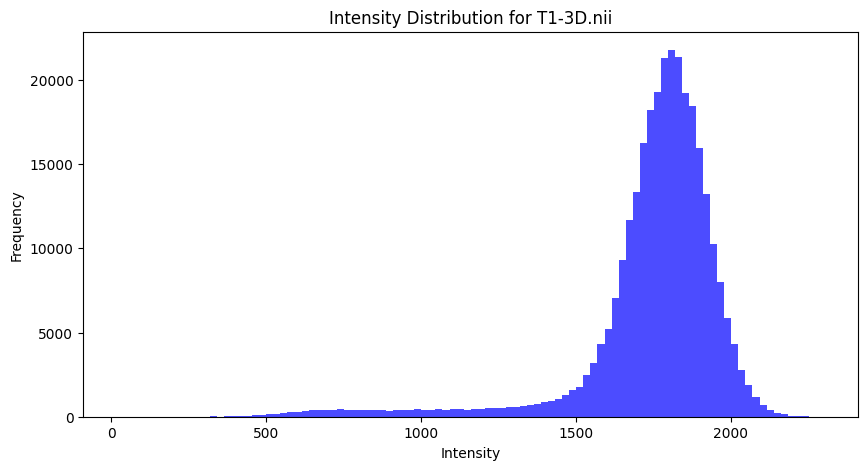

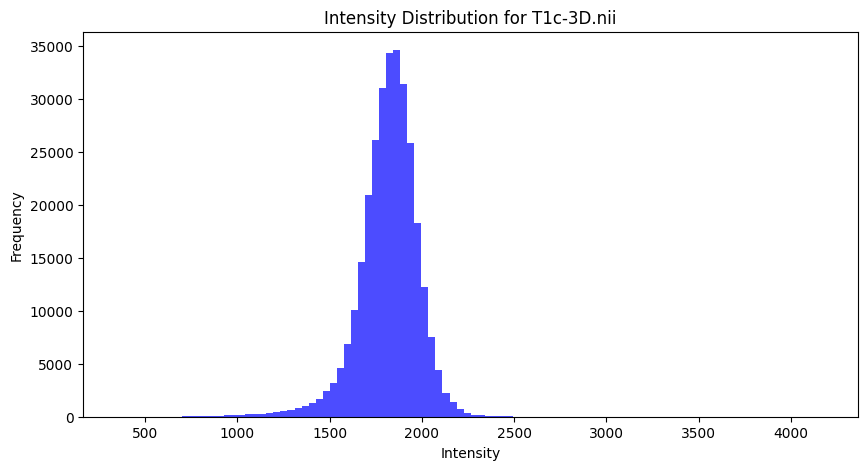

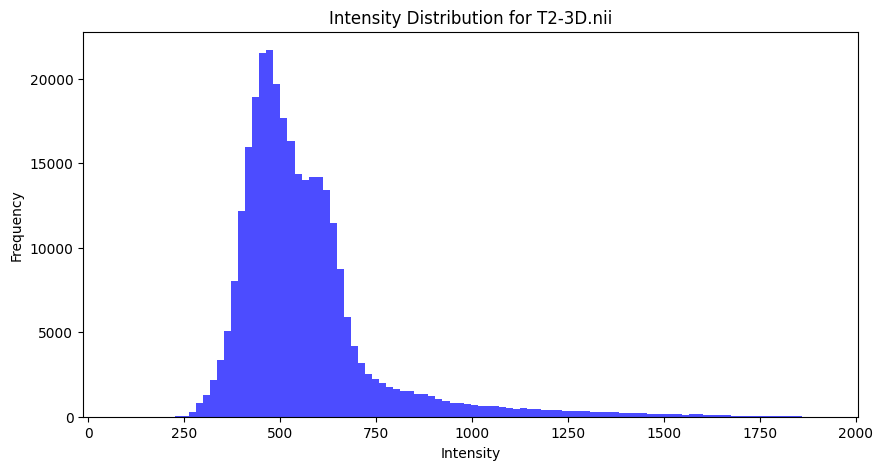

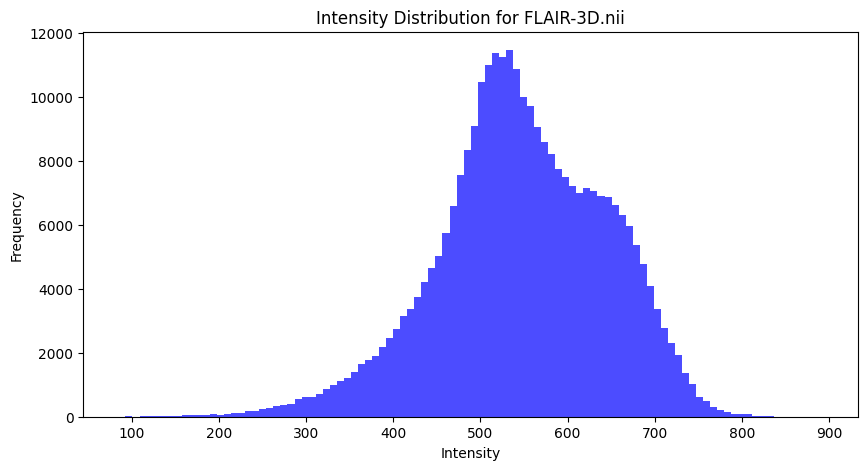

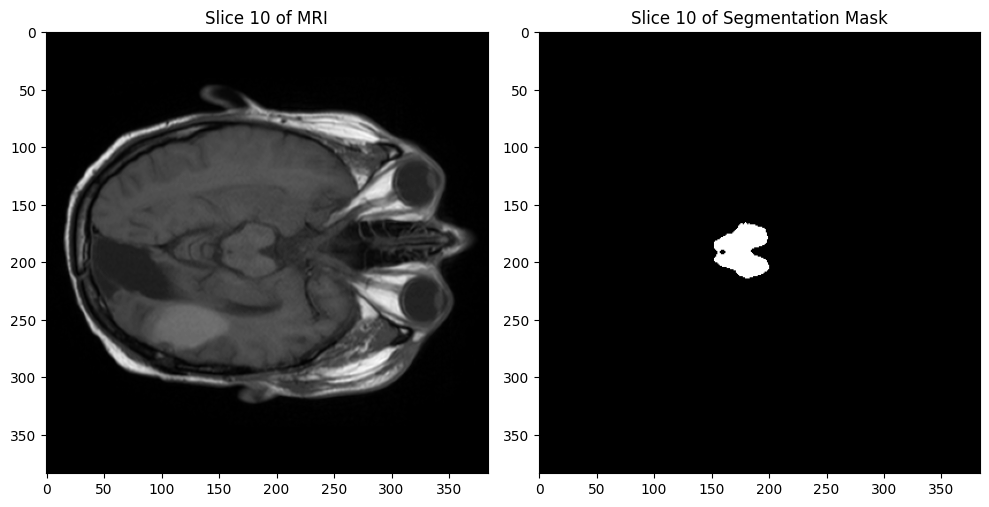

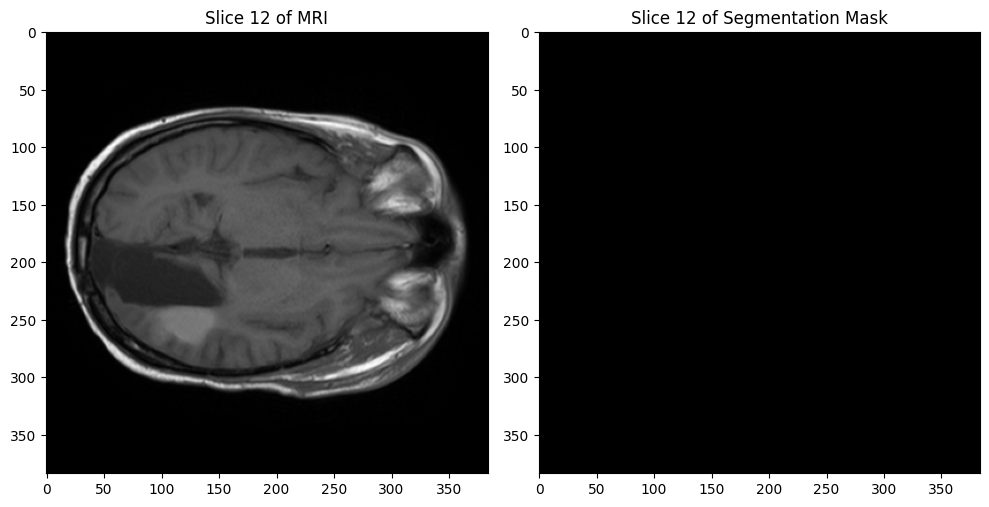

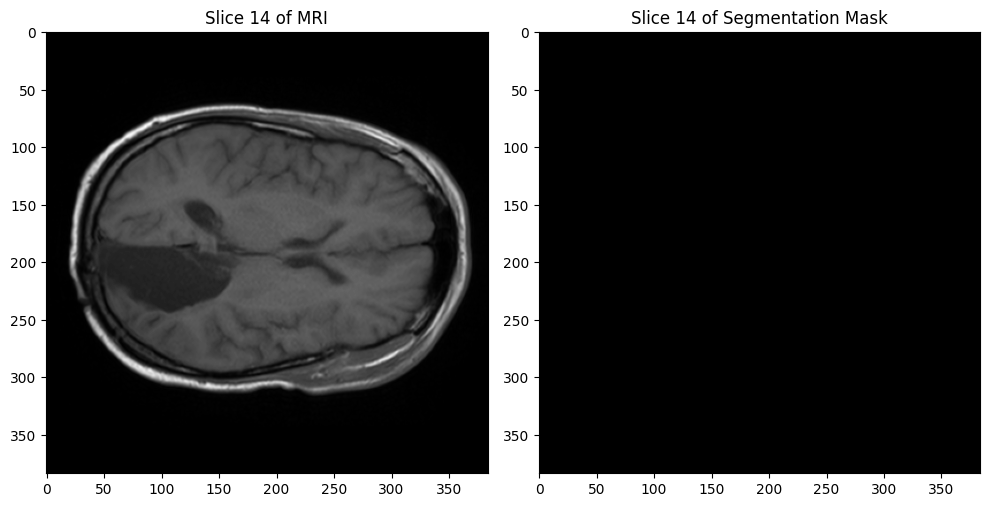

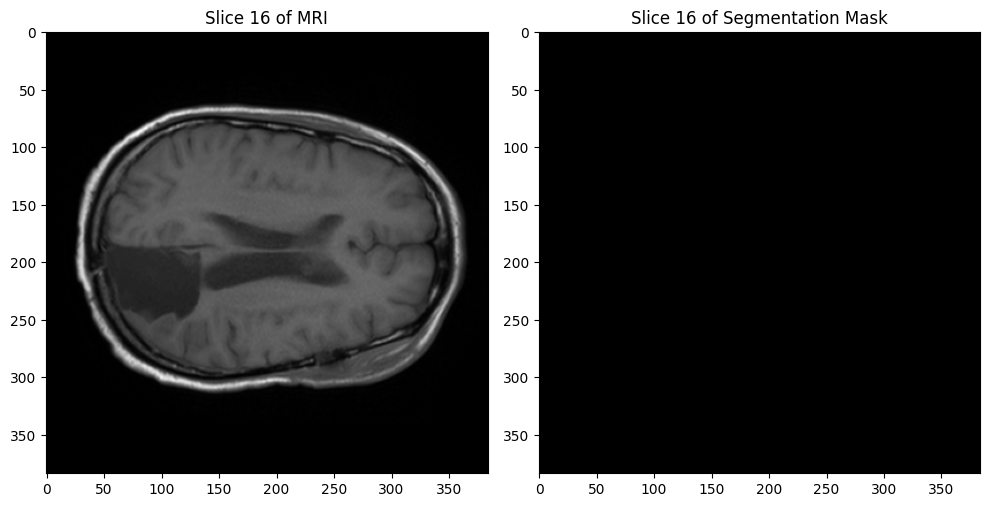

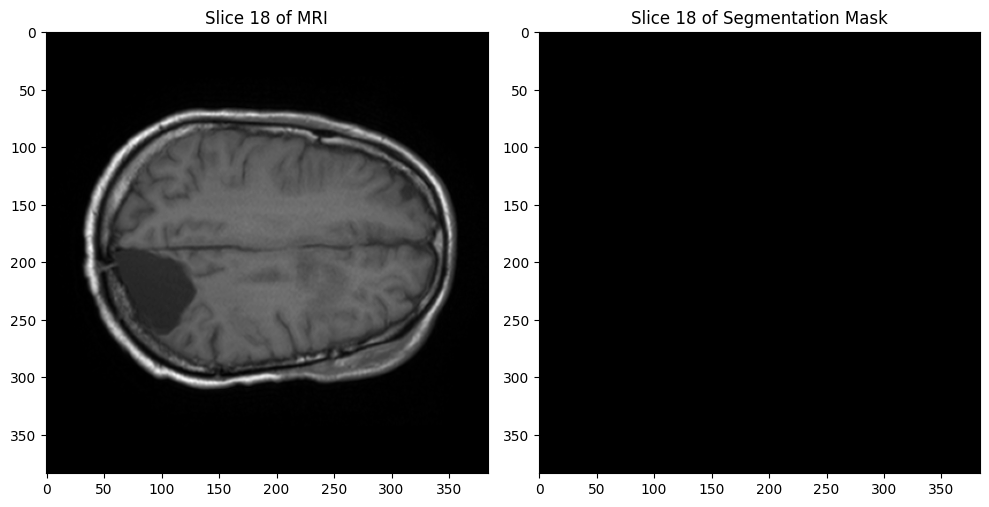

In [6]:
# Cell 6: Intensity Distribution Analysis
def plot_intensity_histogram(patient_data, bins=100):
    sequence_types = ['T1-3D.nii', 'T1c-3D.nii', 'T2-3D.nii', 'FLAIR-3D.nii']
    for sequence in sequence_types:
        data = patient_data[sequence]
        
        # Exclude zero intensities
        non_zero_data = data[data > 0]
        
        plt.figure(figsize=(10,5))
        plt.hist(non_zero_data.ravel(), bins=bins, color='blue', alpha=0.7)
        plt.title(f"Intensity Distribution for {sequence}")
        plt.xlabel("Intensity")
        plt.ylabel("Frequency")
        plt.show()

plot_intensity_histogram(random_patient)



def visualize_mask_and_mri(mri_path, seg_path):
    mri_data, seg_data = load_data(mri_path, seg_path)
    slice_indices = np.linspace(10, mri_data.shape[2] - 10, 5).astype(int)
    
    for idx in slice_indices:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(mri_data[:, :, idx], cmap='gray')
        axes[0].set_title(f"Slice {idx} of MRI")
        
        axes[1].imshow(seg_data[:, :, idx], cmap='gray')
        axes[1].set_title(f"Slice {idx} of Segmentation Mask")
        
        plt.tight_layout()
        plt.show()

random_patient = np.random.choice(all_patient_data)
random_patient_id = str(random_patient['patient_id'])
random_mri_path = os.path.join(data_dir, random_patient_id, 'T1-3D.nii')
random_seg_path = os.path.join(data_dir, random_patient_id, 'Segmentation.seg.nrrd')
visualize_mask_and_mri(random_mri_path, random_seg_path)




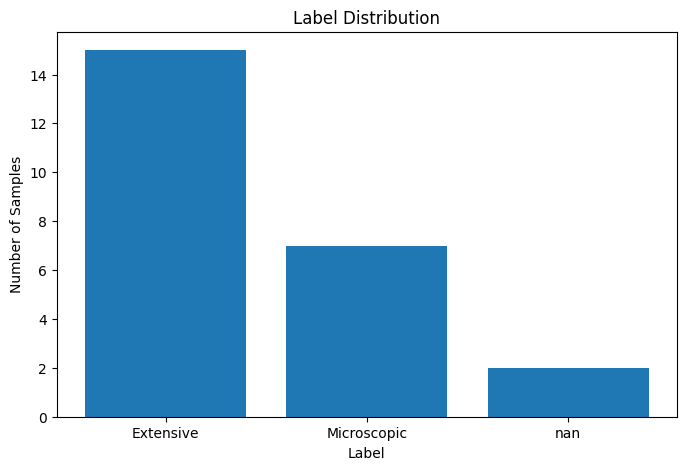

In [7]:
# Cell 7: Label Distribution Analysis
def display_label_distribution(labels):
    plt.figure(figsize=(8,5))
    
    # Convert labels to string type to ensure they are interpreted correctly
    labels = [str(label) for label in labels]
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    plt.bar(unique_labels, counts)
    plt.title("Label Distribution")
    plt.xlabel("Label")
    plt.ylabel("Number of Samples")
    plt.show()

display_label_distribution(all_labels)


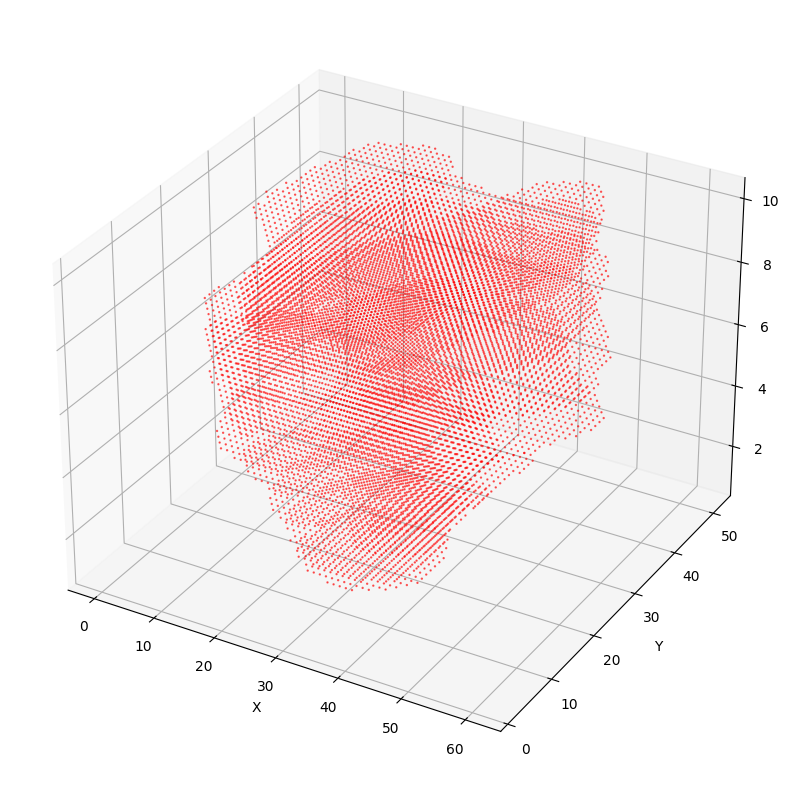

In [8]:
# Cell 8: Optional 3D Visualization of Random Patient Data
visualize_3d_roi(random_patient['T1-3D.nii'], 'T1-3D.nii')


In [ ]:
class PatientDataset(Dataset):
    def __init__(self, all_patient_data, labels_array, patches_per_sample=10, resize_shape=(100, 100, 100)):
        self.data = all_patient_data
        # Replicate each label 'patches_per_sample' times to match the number of patches
        self.labels = [self.map_label(labels_array[patient_idx]) for patient_idx, _ in enumerate(all_patient_data) for _ in range(patches_per_sample)]
        self.patch_size = (16, 16, 16)  # Desired patch size
        self.patches_per_sample = patches_per_sample  # Number of patches to extract per sample
        self.resize_shape = resize_shape

    def map_label(self, label):
        if label == "Extensive":
            return [1, 0, 0]
        elif label == "None":
            return [0, 1, 0]
        else:
            return [0, 0, 1]
        

    def resize_sequence(self, sequence):
        # Use scipy's zoom to resize the sequence based on the resize_shape attribute
        factors = (self.resize_shape[0]/sequence.shape[0], 
                   self.resize_shape[1]/sequence.shape[1], 
                   self.resize_shape[2]/sequence.shape[2])
        return resize(sequence, factors)

                                 
    def __len__(self):
        return len(self.data) * self.patches_per_sample

    def __getitem__(self, index):
        # Determine the actual patient sample and patch index
        patient_idx = index // self.patches_per_sample
        patch_idx = index % self.patches_per_sample  # This is not used but is here for clarity
        
        patient_data = self.data[patient_idx]

        # Process the sequences
        sequence_types = ['T1-3D.nii', 'T1c-3D.nii', 'T2-3D.nii', 'FLAIR-3D.nii']
        sequences = []
        for sequence_type in sequence_types:
            tensor = patient_data[sequence_type].astype(np.float32)
            tensor = self.resize_sequence(tensor)
            
            # Randomly select a starting point for the patch
            start_x = np.random.randint(0, tensor.shape[0] - self.patch_size[0])
            start_y = np.random.randint(0, tensor.shape[1] - self.patch_size[1])
            start_z = np.random.randint(0, tensor.shape[2] - self.patch_size[2])

            # Extract the patch
            patch = tensor[start_x:start_x + self.patch_size[0],
                           start_y:start_y + self.patch_size[1],
                           start_z:start_z + self.patch_size[2]]

            sequences.append(torch.from_numpy(patch))

        # Stack the sequences into a single tensor
        tensor = torch.stack(sequences).squeeze(1)
        label = torch.tensor(self.labels[patient_idx], dtype=torch.float32)

        return tensor, label, patient_idx

data = np.load('/home/slt2870/Glioblastoma_Infillstration_Classification/processed_patient_data.npy', allow_pickle=True)
labels = np.load('/home/slt2870/Glioblastoma_Infillstration_Classification/labels.npy', allow_pickle=True)


In [30]:
# Parameters
model_name = "resnet10"
current_date = datetime.datetime.now().strftime('%Y%m%d')
lr = 1e-4
n_input_channels = 4
num_classes = 3
num_epochs = 10

# Define log directory and filename
log_dir = "/home/slt2870/Glioblastoma_Infillstration_Classification/logs"
log_file = f"{model_name}_{current_date}_lr{lr}_epochs{num_epochs}.txt"
log_path = os.path.join(log_dir, log_file)

# Check and create log directory if it doesn't exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Set up logging
logging.basicConfig(filename=log_path, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())  # Also log to console

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up 4-fold stratified cross-validation
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(data, labels)):
    
    train_data, train_labels = data[train_idx], labels[train_idx]
    test_data, test_labels = data[test_idx], labels[test_idx]
    
    train_dataset = PatientDataset(train_data, train_labels, patches_per_sample=10)
    test_dataset = PatientDataset(test_data, test_labels, patches_per_sample=10)
    
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
    
    # Initialize the ResNet model
    model = resnet10(spatial_dims=3, n_input_channels=n_input_channels, num_classes=num_classes, pretrained=False)
    model.to(device)  # Transfer model to GPU

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets, patient_idxs in train_loader:  # Updated this line
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(targets, dim=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()


        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Training Loss: {epoch_loss/len(train_loader):.4f}")
        
    # Test loop
    model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    misclassified_patient_ids = []
    
    with torch.no_grad():
        for inputs, targets, patient_idxs in test_loader:  # Assume dataset returns patient_idxs
            inputs, targets = inputs.to(device), targets.to(device)  # Transfer data to GPU
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_samples += targets.size(0)
            total_correct += (predicted == torch.argmax(targets, dim=1)).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(torch.argmax(targets, dim=1).cpu().numpy())
            
            # Track misclassified samples
            for i, pred in enumerate(predicted):
                if pred != torch.argmax(targets[i], dim=0):
                    misclassified_patient_ids.append(patient_idxs[i].item())
    
    accuracy = total_correct / total_samples
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print(f"Fold {fold + 1}, Test Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print(f"Misclassified Patient IDs in Fold {fold + 1}: {misclassified_patient_ids}")

    # Save model weights
    torch.save(model.state_dict(), f"model_fold_{fold + 1}.pth")


/home/slt2870/ENTER/envs/gbm/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


KeyboardInterrupt: 